**Attention Is All You Need** -> https://arxiv.org/abs/1706.03762

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# import pandas as pd
# import numpy as np
# from torch.utils.data import DataLoader
import math

### Implementation of Encoder and Self attention and Multihead attention

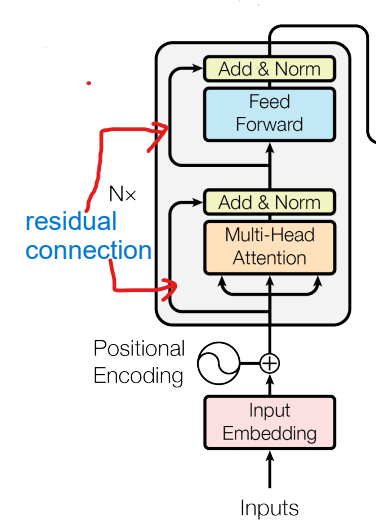

### Residual connection :

The idea of residual learning is taken from the RESNET paper :https://arxiv.org/abs/1512.03385

**NOTE**:I have studied only relevant portion from the RESNET paper i.e residual learning and skip connections..


### what problem occurs in deep neural networks ??

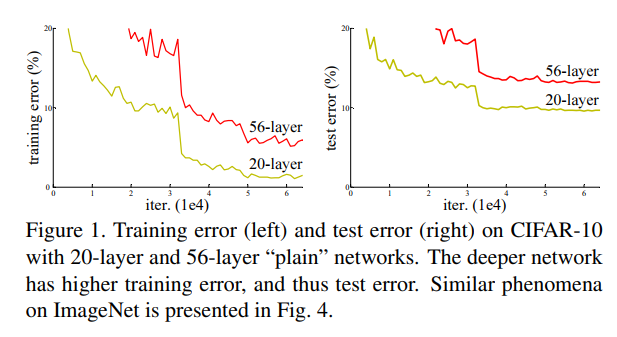

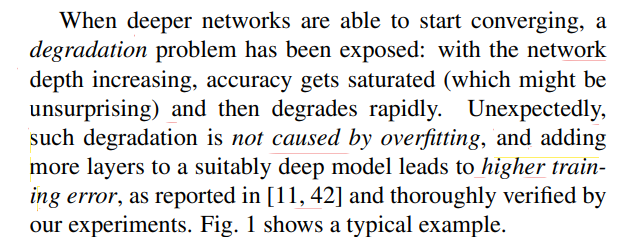

The degradation (of training accuracy) indicates that not
all systems are similarly easy to optimize.

residual connections to stabilize training and enable deeper networks.

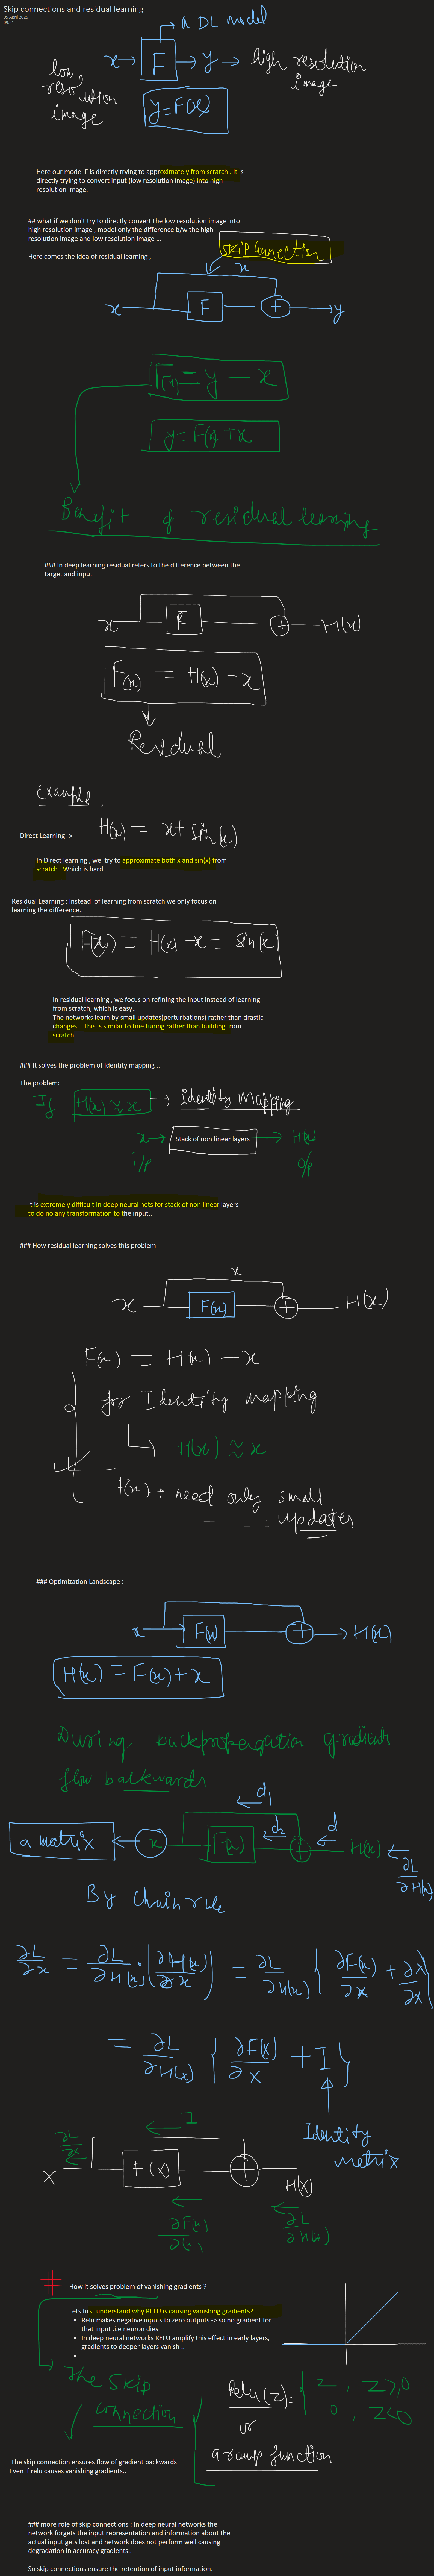

### relation with the attention transformer

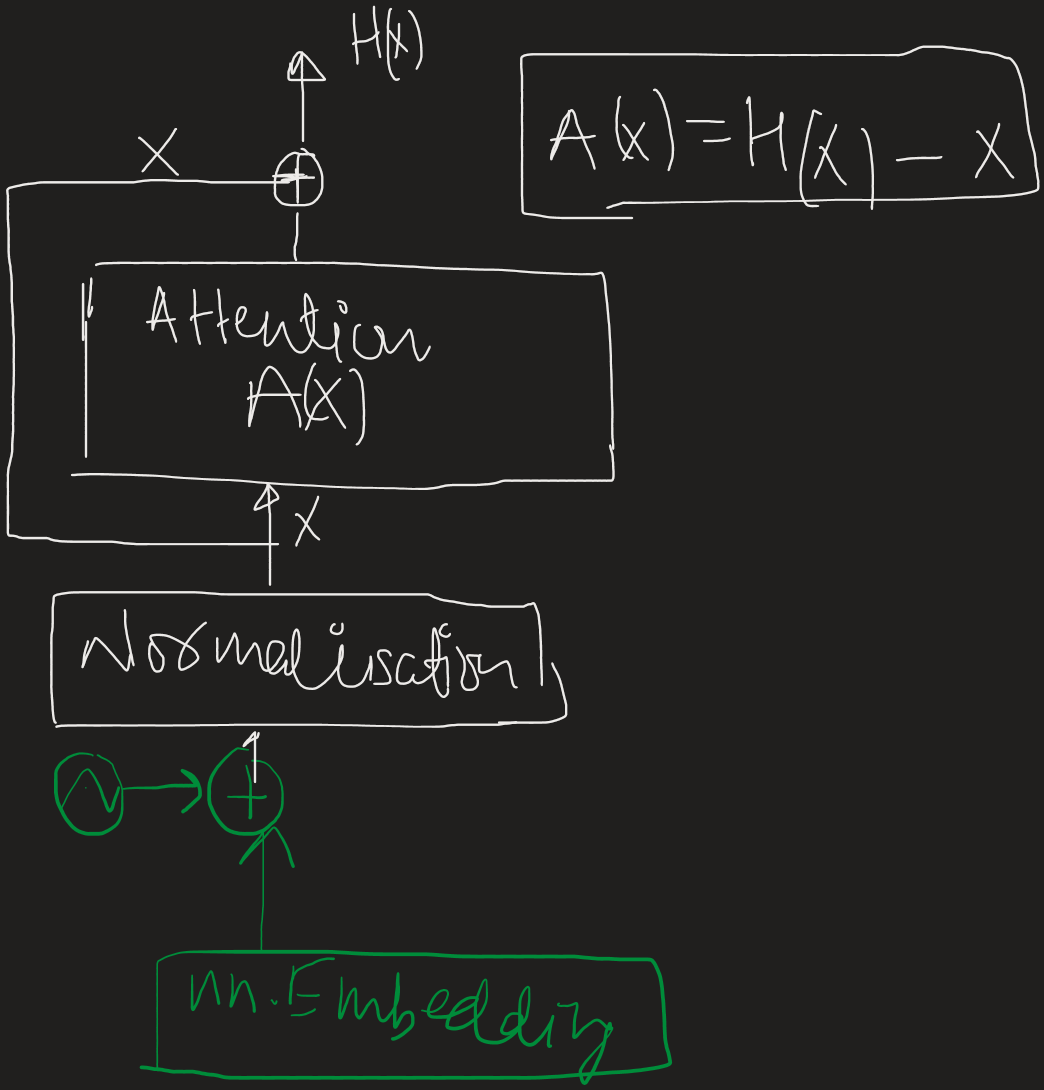

A(x) attention represents **contextual representations** through giving weights to tokens by attention mechanism.

Make incremental updates in A(x) to capture relationships between tokens.

This the Encoder part of the Original Transformer.

In [ ]:
raw_text = "I am a human and you are an AI"
tokenized = raw_text.split(" ")
tokenized

['I', 'am', 'a', 'human', 'and', 'you', 'are', 'an', 'AI']

In [ ]:
len(tokenized)
# context length

9

### I am considering context length to be the length of list of tokens

### Position Encoding

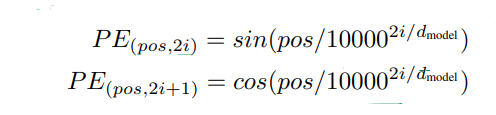

### we should avoid nested loops to code the positional encoding, we should apply vectorized operations

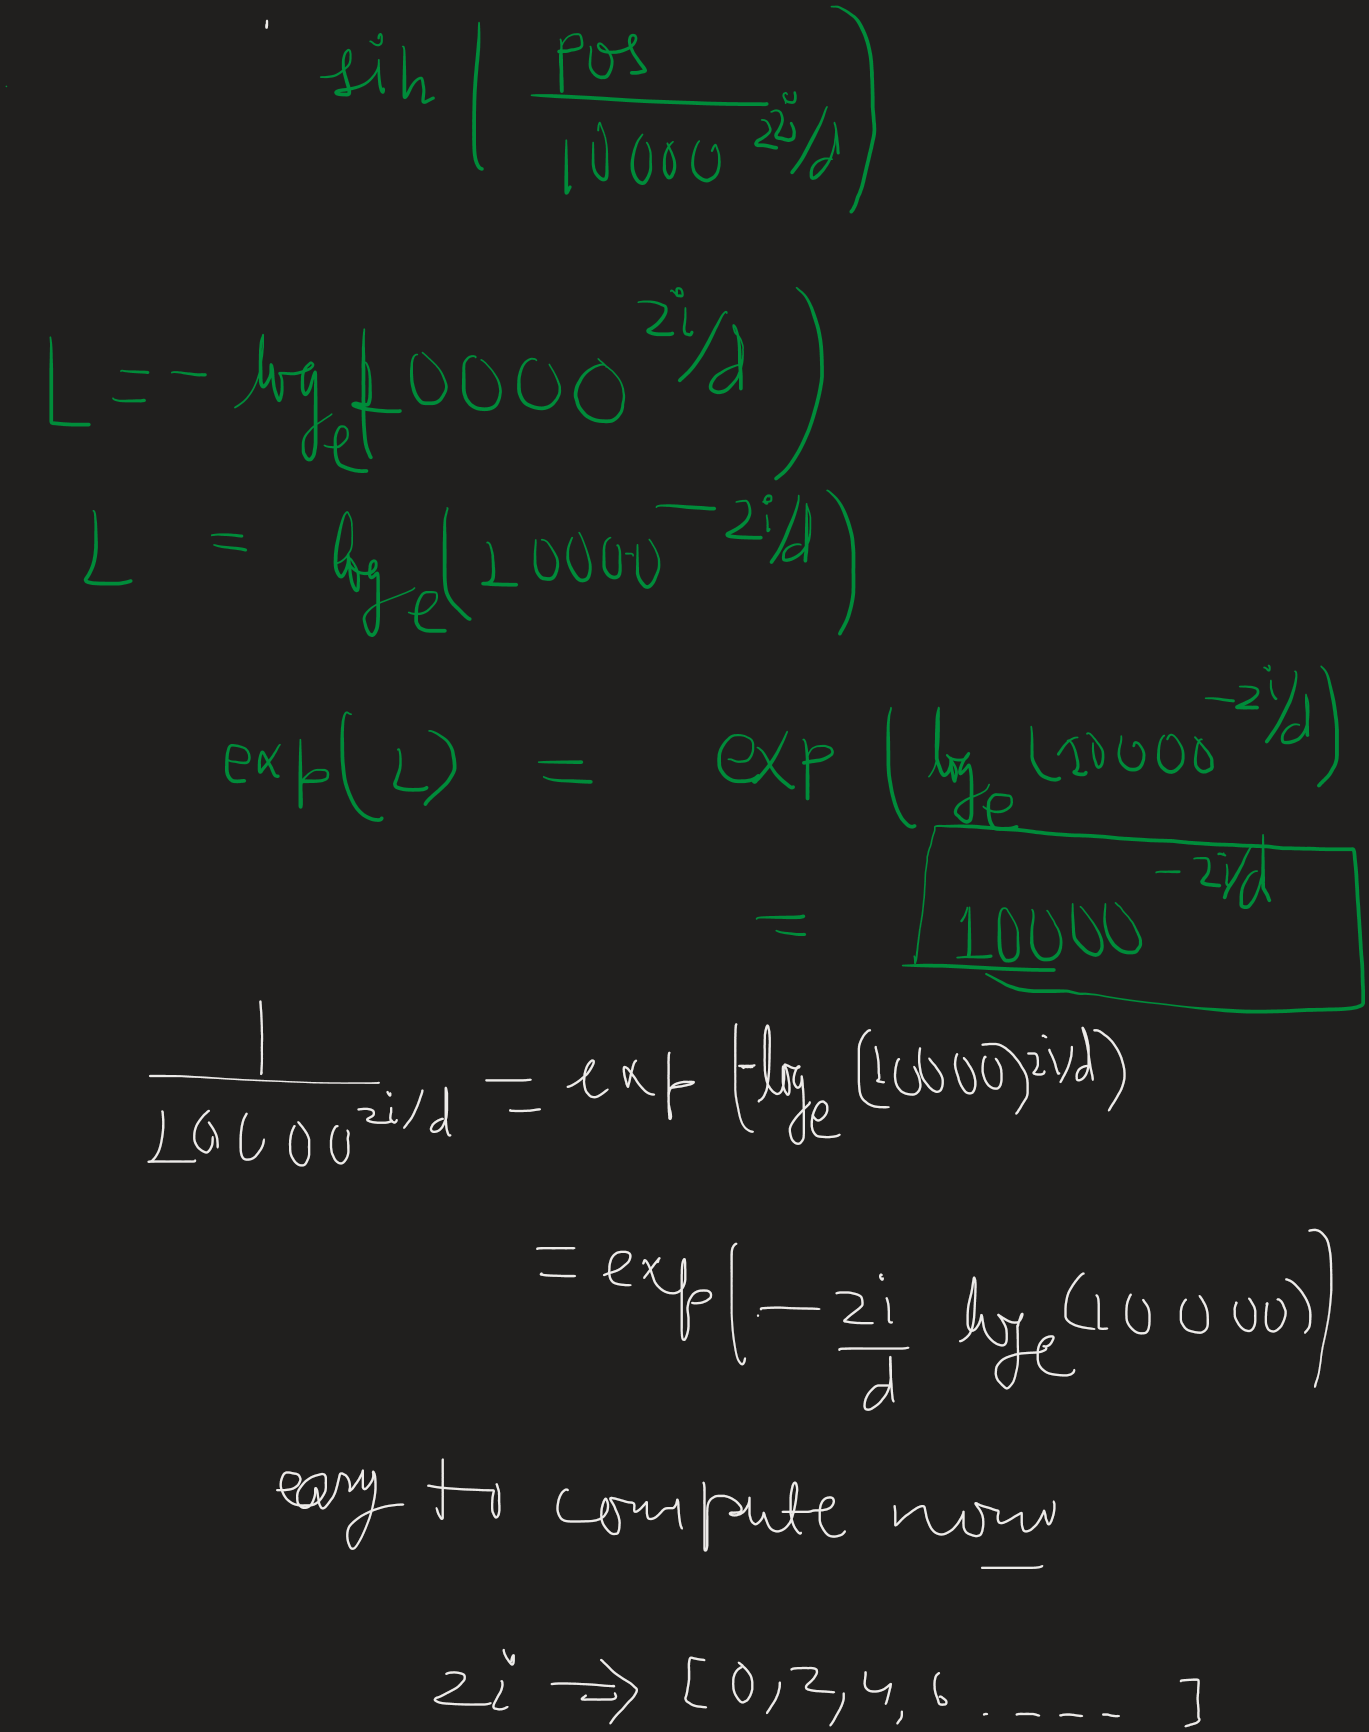

In [ ]:
def Positional_Encoding(T,dmodel):
  # need context length
  pos_encode = torch.zeros(T,dmodel)
  pos = torch.arange(0,T).unsqueeze(1)

  log_den = torch.arange(0,dmodel,2)*(-math.log(10000)/dmodel)
  den_ = torch.exp(log_den)

  pos_encode[:,0::2] = torch.sin(pos*den_)
  pos_encode[:,1::2] = torch.cos(pos*den_)

  return pos_encode

In [ ]:
Positional_Encoding(5,10)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  1.5783e-01,  9.8747e-01,  2.5116e-02,
          9.9968e-01,  3.9811e-03,  9.9999e-01,  6.3096e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  3.1170e-01,  9.5018e-01,  5.0217e-02,
          9.9874e-01,  7.9621e-03,  9.9997e-01,  1.2619e-03,  1.0000e+00],
        [ 1.4112e-01, -9.8999e-01,  4.5775e-01,  8.8908e-01,  7.5285e-02,
          9.9716e-01,  1.1943e-02,  9.9993e-01,  1.8929e-03,  1.0000e+00],
        [-7.5680e-01, -6.5364e-01,  5.9234e-01,  8.0569e-01,  1.0031e-01,
          9.9496e-01,  1.5924e-02,  9.9987e-01,  2.5238e-03,  1.0000e+00]])

## a question , when I create multiple heads do I need all of the heads to have the same parameters or different ???
-

->Purpose of multihead attention:
Instead of performing a single attention function with dmodel-dimensional keys, values and queries,
we found it beneficial to linearly project the queries, keys and values h times with **different, learned
linear projections** to dk, dk and dv dimensions, respectively..

-> multiple heads with their own linear projections

Why multihead?

* Different heads can learn to focus on different aspects of the input (e.g., syntax, semantics, long-range dependencies).
* Multiple heads can be computed in parallel, improving efficiency.
* Since each head operates in a lower-dimensional space (d_k = d_model / h), the total computation is similar to single-head attention but with richer representations.

### Parallel computation
"computed in parallel" means that the calculations for each attention head are independent of each other and can be processed simultaneously (rather than sequentially), taking advantage of modern hardware (GPUs/TPUs) that support parallel computation.


The parallel computation in multi-head attention (and many other parts of deep learning) is made possible by efficient matrix and tensor operations, which are optimized to run simultaneously on hardware like GPUs and TPUs.


### I will be doing something different which is considered to produce good results, normalising before attention and feedforward part..

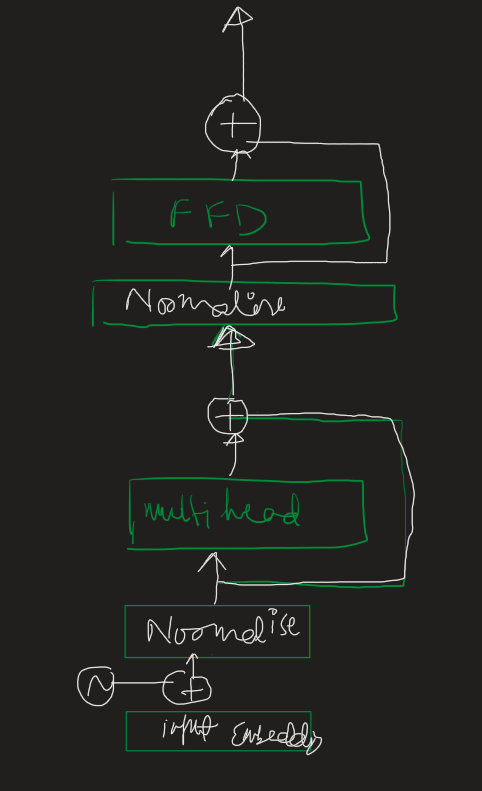

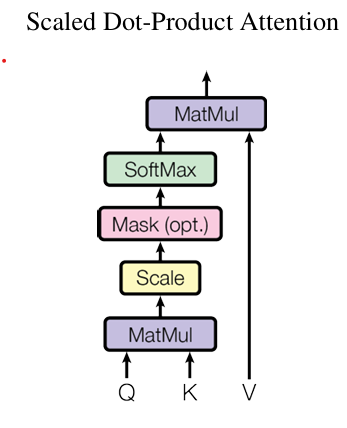

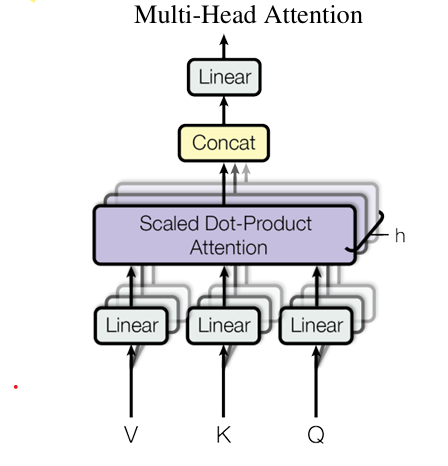

### the linear layer at the end of multihead attention is for changing the shape from (batch,context_length,n_heads*dv) to (batch,context_length , dmodel)

In [ ]:
class Encoder(nn.Module):

  def __init__(self,dmodel:int,dk:int,
               dv:int,dff:int,n_heads = n_heads,masking = False):
    super().__init__()
    self.dmodel = dmodel
    self.dk = dk
    self.dv = dv
    self.n_heads = n_heads
    self.shape_changer = nn.Linear(n_heads*dv,dmodel,bias = False)
    self.masking = masking

    # feeforward network
    self.f1 = nn.Linear(dmodel,dff)
    self.f2 = nn.Linear(dff,dmodel)

    # layer normalise
    self.first_norm = nn.LayerNorm(dmodel)
    self.second_norm = nn.LayerNorm(dmodel)


  def MultiHead(self,input:torch.tensor):
    self.heads = nn.ModuleList([])
    for i in range(n_heads):
      self.heads.append(self.Single_Head_attention(self.dmodel,self.dk,self.dv))

    multi_head = []
    for head in self.heads:
      multi_head.append(head.forward(input))
    concat_multi = torch.cat(multi_head,dim = -1)

    return self.shape_changer(concat_multi)  ## linear layer at the end of multihead attention...

  def forward(self,input:torch.tensor):
    # first normalise then send it to attention
    norm1 = self.first_norm(input)
    multihead_out = self.MultiHead(norm1)
    norm2 = self.second_norm(norm1+multihead_out)

    # feedforward
    ffd_out = self.f2(F.relu(self.f1(norm2)))

    return (ffd_out + norm2)


  class Single_Head_Attention(nn.Module):
    def __init__(self,dmodel:int,dk:int,dv:int):
      self.W_q = nn.Linear(dmodel,dk,bias = False)
      self.W_k = nn.Linear(dmodel,dk,bias = False)
      self.W_v = nn.Linear(dmodel,dv,bias = False)
      self.dk = dk

    def masked_matrix(self,sim_mat):
      mask = torch.triu(sim_mat,diagonal = 1).bool()

      sim_mat.masked_fill_(mask,-torch.inf)
      # inplace

    def forward(self,input:torch.tensor,masking = False):
      Q = self.W_q(input)
      K = self.W_k(input)
      V = self.W_v(input)
      self.masking = False

      sim_mat = torch.matmul(Q,torch.transpose(Q,1,2))/math.sqrt(self.dk)

      if self.masking:
      self.masked_matrix(sim_mat)
      # call and inplace masking occured sim_mat gets modified inplace

      self.attention_wts = F.softmax(sim_mat,dim = 2) # shape -> (batch size,len(list),len(list))

      head = torch.matmul(self.attention_wts,V)
      return head
      # shape -> (batch size,context length,dv)



The following snapshot is from the paper Attention is all you need

### sqrt(dk) -> numerical stability :

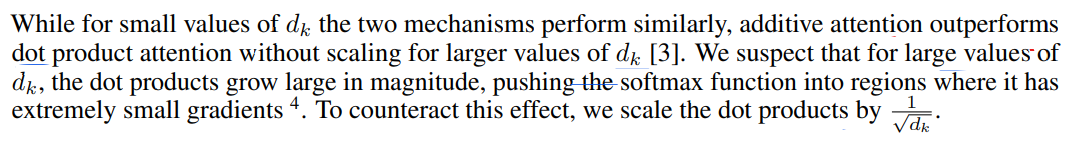



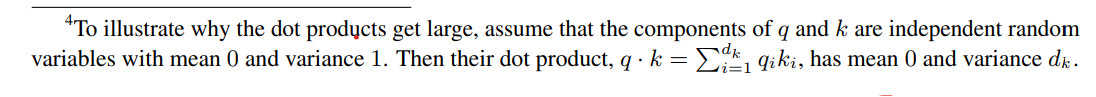

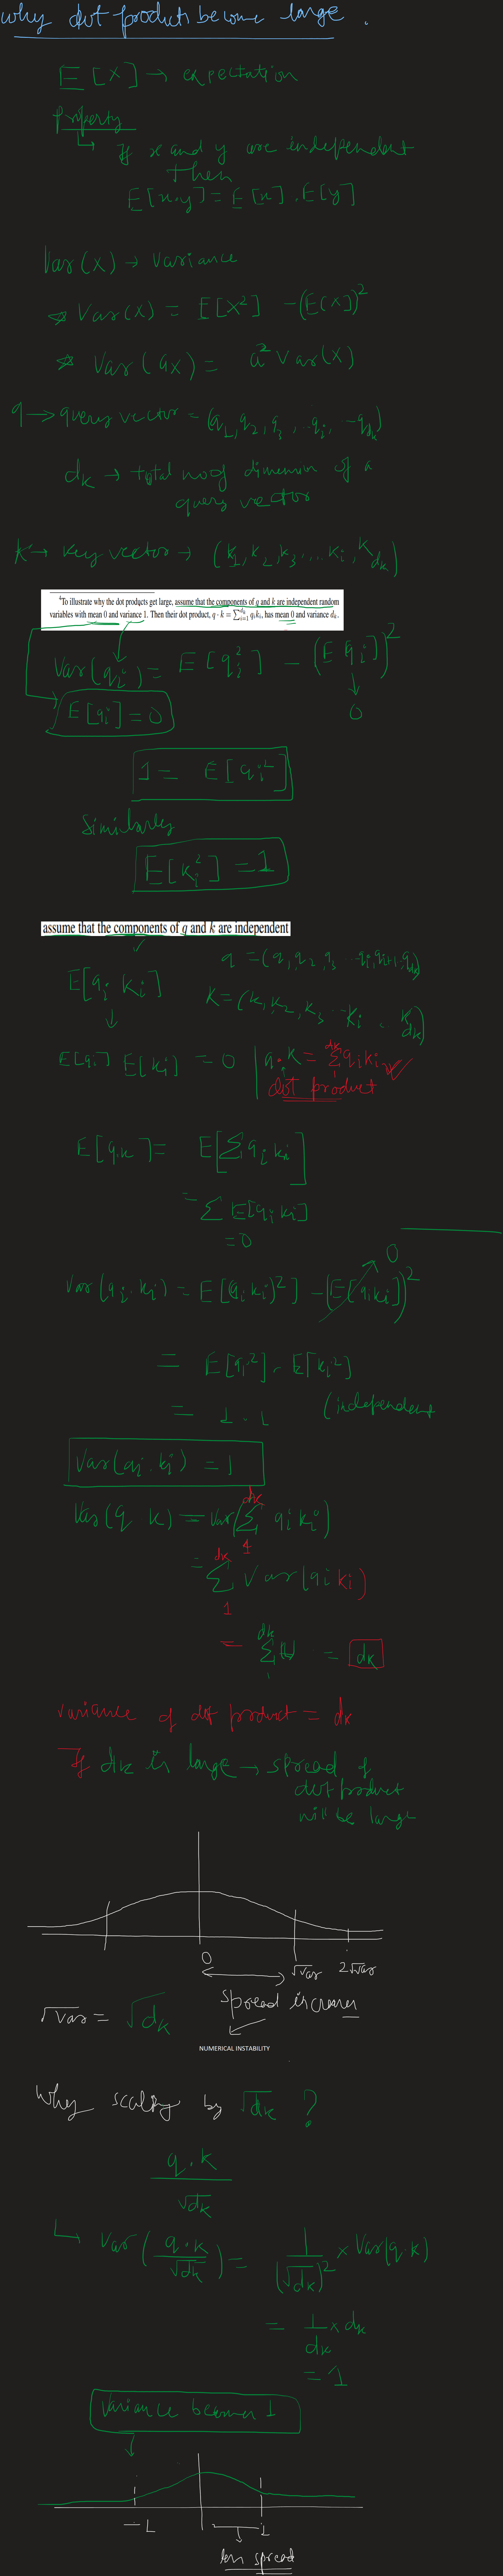

### this was the basic explanation ... sorry for bad handwritting

### need vocabulary and contexts

* word embeddings -> vocabulary
* postional encoding -> contexts

In [ ]:
class input_repr(nn.Module):

  def __init__(self,vocab_size,T,dmodel,pos_encode:bool):
    self.E = nn.Embedding(vocab_size,dmodel)
    self.T = T
    self.pos_encode = False
    self.posit  = self.Positional_Encoding(T,dmodel)

  def Positional_Encoding(T,dmodel):
  # context length == T
    pos_encoding = torch.zeros(T,dmodel)
    pos = torch.arange(0,T).unsqueeze(1)

    log_den = torch.arange(0,dmodel,2)*(-math.log(10000)/dmodel)
    den_ = torch.exp(log_den)

    pos_encoding[:,0::2] = torch.sin(pos*den_)
    pos_encoding[:,1::2] = torch.cos(pos*den_)

    return pos_encoding  ## shape (T X dmodel)

  def forward(self,input_idx):
    # input_idx shape -> batch X context length
    if self.pos_encode:
      return self.E.weight[input_idx] + self.posit


    # shape -> batch X context length X dmodel


### **NOTE** : I have modified this input_repr class in the recommendation program...

In [ ]:
class MyModel(nn.Module):
  def __init__(self,N:int,dmodel:int,dk:int,
               dv:int,dff:int,n_heads = n_heads,masking = False):
    super().__init__()

    self.encoder_stack = nn.Sequential()
    for i in range(N):
      self.encoder_stack.append(copy.deepcopy(Encoder(dmodel,dk,dv,dff,n_heads,masking = False)))

    self.final_norm = nn.LayerNorm(dmodel)

  def forward(self,input:torch.tensor):
    encoder_stack_out = self.encoder_stack(input)
    return self.final_norm(encoder_stack_out)



### Identical layers of Encoders are used in the original transformer.

### stack of encoder : How does the data flow

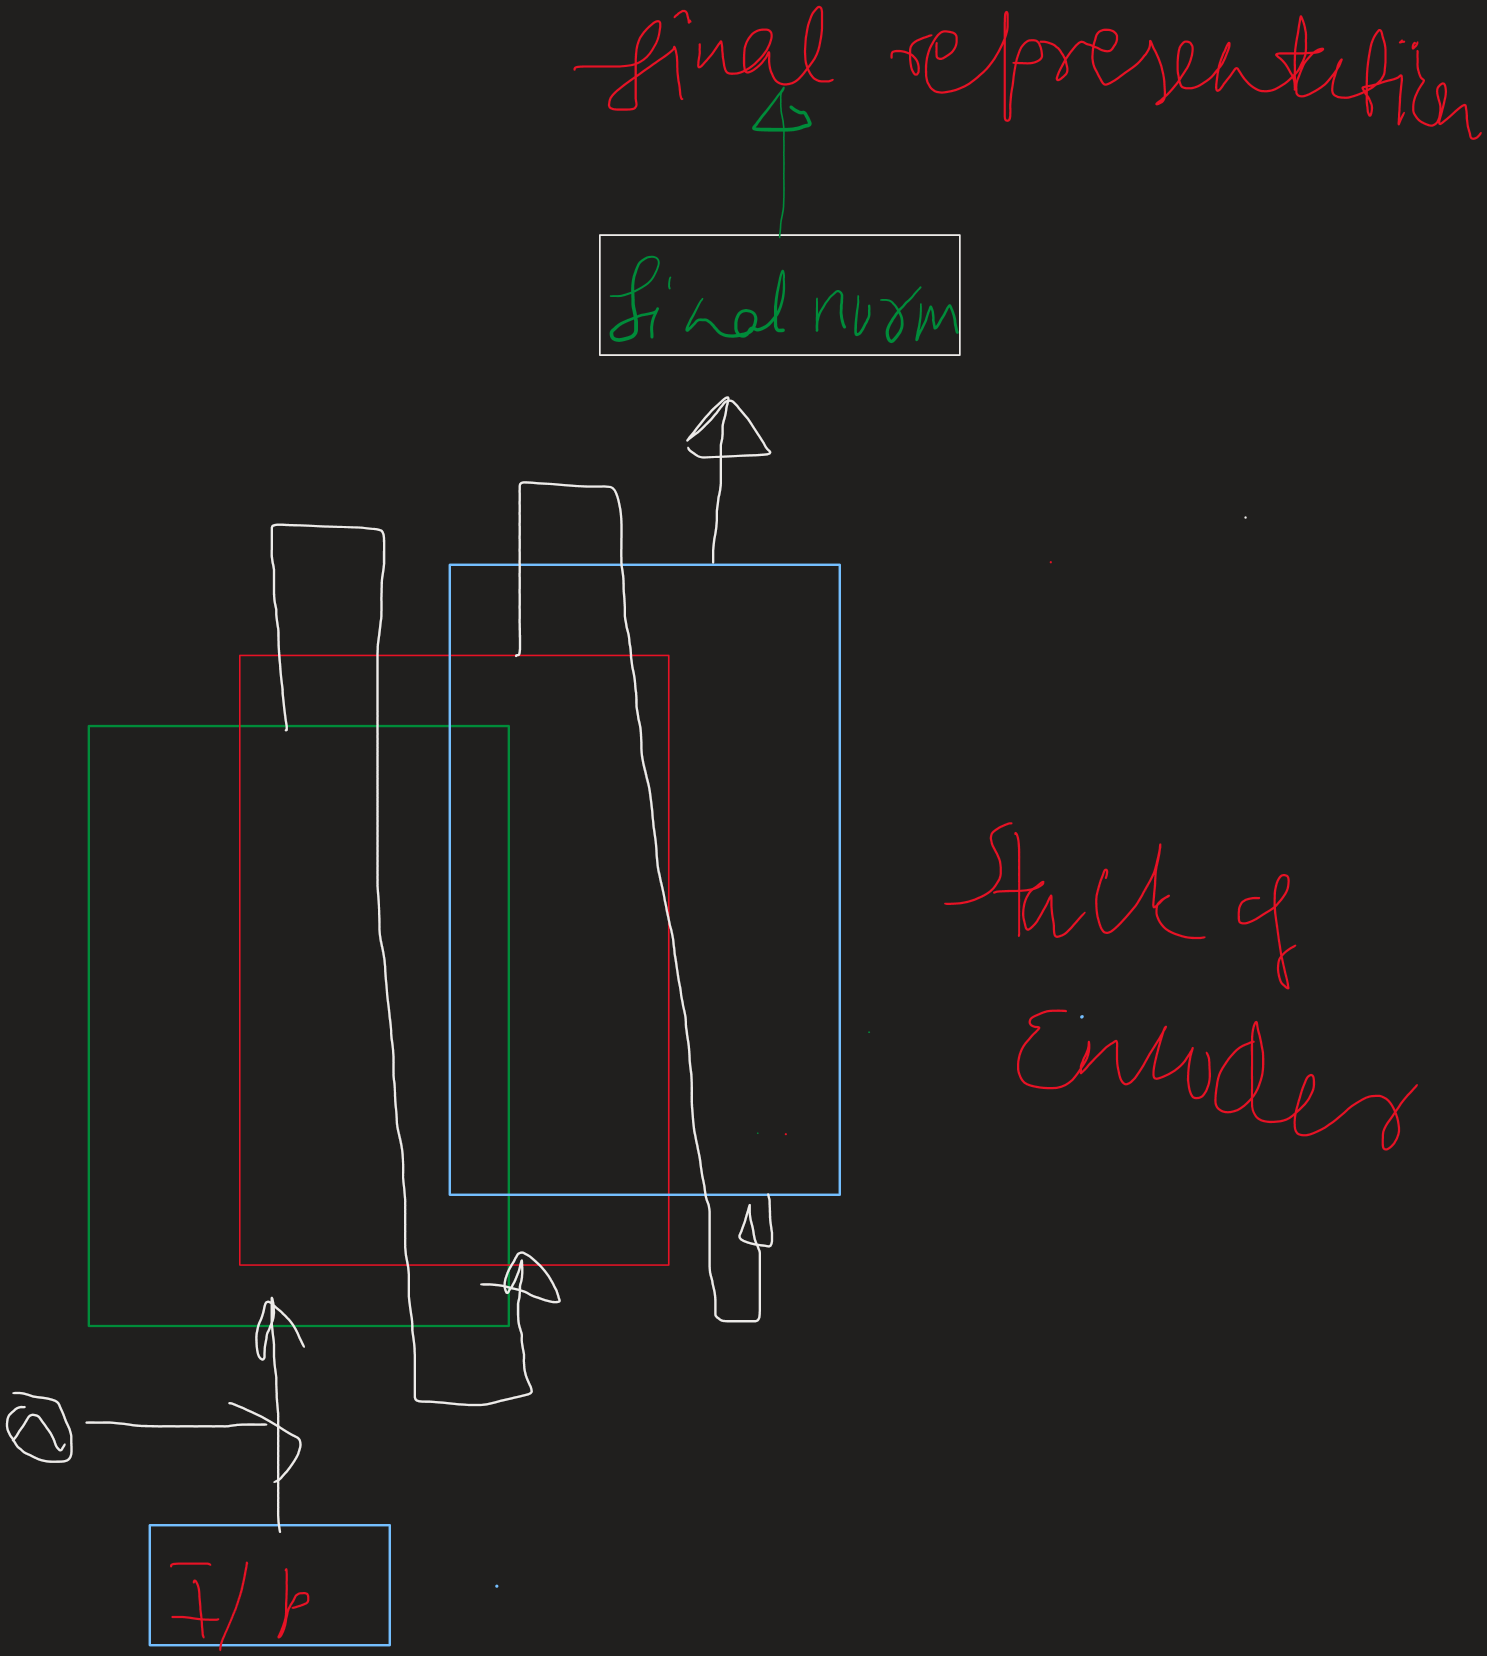

This was it , I have implemented a decoder part but I need to test it properly on a machine translation task which I haven't done yet..I will upload it on github later..Currently I am studying fine tuning , BERT etc to gain more ideas regarding these LLMs...

### this paper below gives us an idea how BERT focuses on tokens

What Does BERT Look At? An Analysis of BERT's Attention
https://arxiv.org/abs/1906.04341